# EDA for Ar41 snapshots
After a preliminary analysis on the simulated data and time considerations, we observed that:
- Some events have Ar41 produced outside the ROI, then the detected events (*where entries have NPE>0*) have detections that don't concern Ar41 de-excitation, rather other processes, such as involving Ar40.
- The existance of other processes could cause the acquisition of snapshot not including the Ar41 detection. For example, if the neutron scatter leading to a detection, the acquisition starts there and lasts for 10us. If the Ar41 de-excitation occurs after this time, it pass undetected.

We then chooose to consider only events close to the shroud (*Ar41 production point within radial distance 1m*). Concerning the cut, we observe a loose in energy that is significant (*1-2 MeV*)in ~200 events.
Since this fraction is small, we consider this kind of data noisy but we have no other trigger strategy for the moment.

In the previous notebook, we cut 14K events with Ar41 produced within 1m. Among these, we have 11K events with at least 1 PE detected. Than, we expect this number of events. Recall that we have simulated 2M events.

In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 20})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=1000):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Neutrons_Cut1000mm_09_04_2020", "Neutrons_Snapshots")

fileinprefix = "SnapshotAr41*.csv"
df_ar41 = load_dataframe_from_files(dirin, fileinprefix)
df_ar41 = df_ar41[df_ar41.columns[:-1]]

print("[Info] Loaded data in {:.3f} seconds".format(time.time() - init))

[Info] Loading 1 files wt prefix:
SnapshotAr41*.csv

[Info] Loaded data in 0.028 seconds


In [4]:
df_ar41.eventnumber.nunique()

11733

In [20]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

def compute_features(row):
    rownp = row.to_numpy()
    return [np.sum(rownp),                        # NPE
            np.nonzero(rownp)[0].shape[0],        # NActiveSlices
            np.mean(rownp),                       # Mean NPE
            np.std(rownp),                        # Std NPE
            np.nonzero(rownp)[0][-1] - np.nonzero(rownp)[0][0] + 1,    # Range
            np.var(np.repeat(np.argwhere(rownp>0), rownp[rownp>0])),   # Var
            np.std(np.repeat(np.argwhere(rownp>0), rownp[rownp>0]))]   # Var   

In [28]:
feat = pd.DataFrame()
inner_slices, outer_slices = 12, 20
feat["PEDetected_inner"] = df_ar41.iloc[:, 3:3+inner_slices].apply(lambda row: pe_detected(row), axis=1)
feat["NActiveSlices_inner"] = df_ar41.iloc[:, 3:3+inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
feat["SpatialRange_inner"] = df_ar41.iloc[:, 3:3+inner_slices].apply(lambda row: range_detections(row), axis=1)
feat["SpatialStd_inner"] = df_ar41.iloc[:, 3:3+inner_slices].apply(lambda row: spatial_std(row), axis=1)
feat["PEDetected_outer"] = df_ar41.iloc[:, 3+inner_slices:3+inner_slices+outer_slices].apply(lambda row: pe_detected(row), axis=1)
feat["NActiveSlices_outer"] = df_ar41.iloc[:, 3+inner_slices:3+inner_slices+outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
feat["SpatialRange_outer"] = df_ar41.iloc[:, 3+inner_slices:3+inner_slices+outer_slices].apply(lambda row: range_detections(row), axis=1)
feat["SpatialStd_outer"] = df_ar41.iloc[:, 3+inner_slices:3+inner_slices+outer_slices].apply(lambda row: spatial_std(row), axis=1)

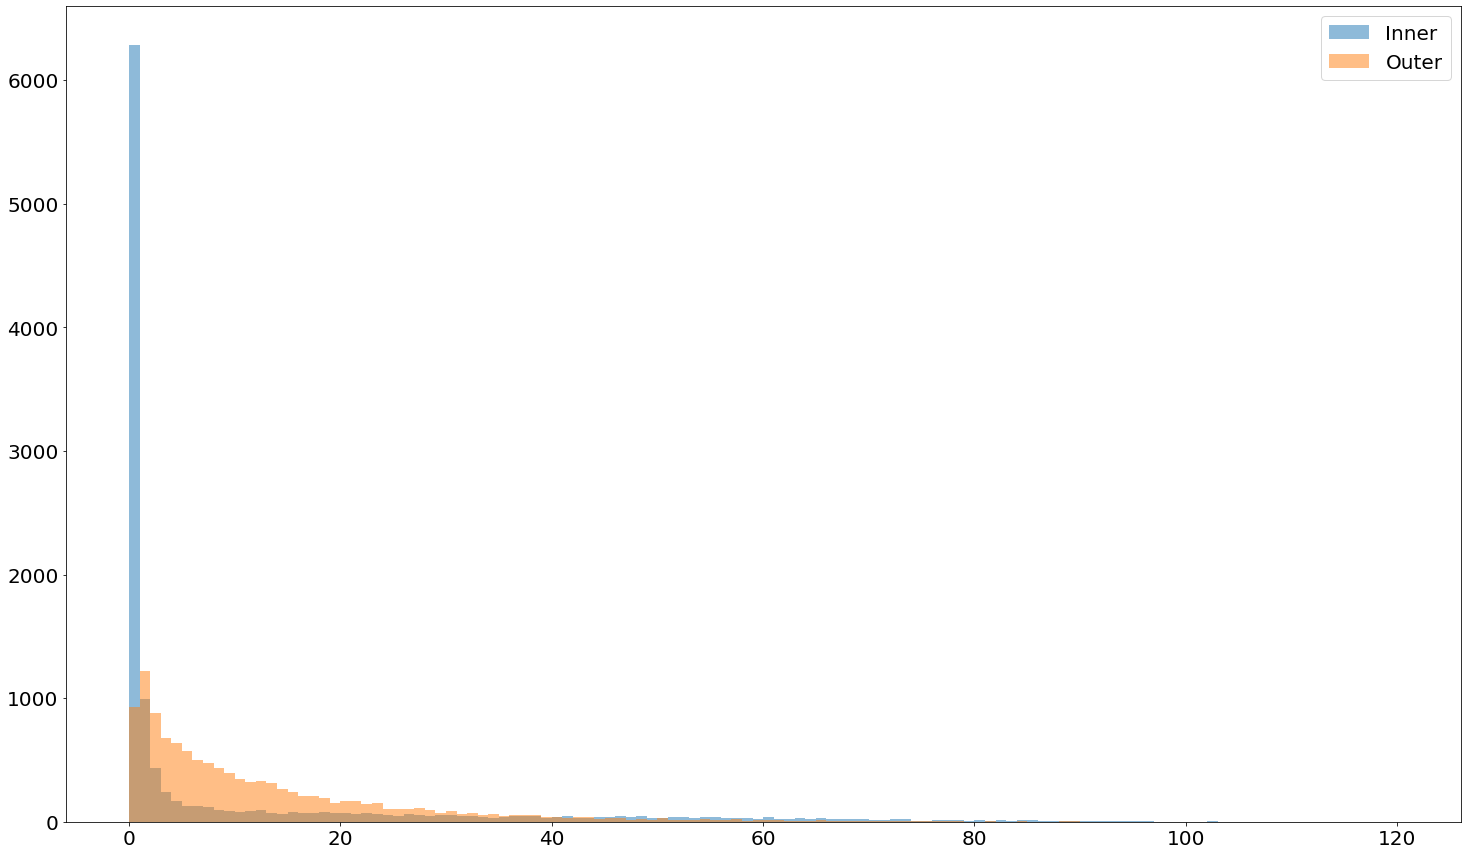

In [41]:
bins=np.linspace(0, 120, 121)
alpha=.5
plt.hist(feat.PEDetected_inner, bins=bins, alpha=alpha, label="Inner")
plt.hist(feat.PEDetected_outer, bins=bins, alpha=alpha, label="Outer")
plt.legend()
plt.show()

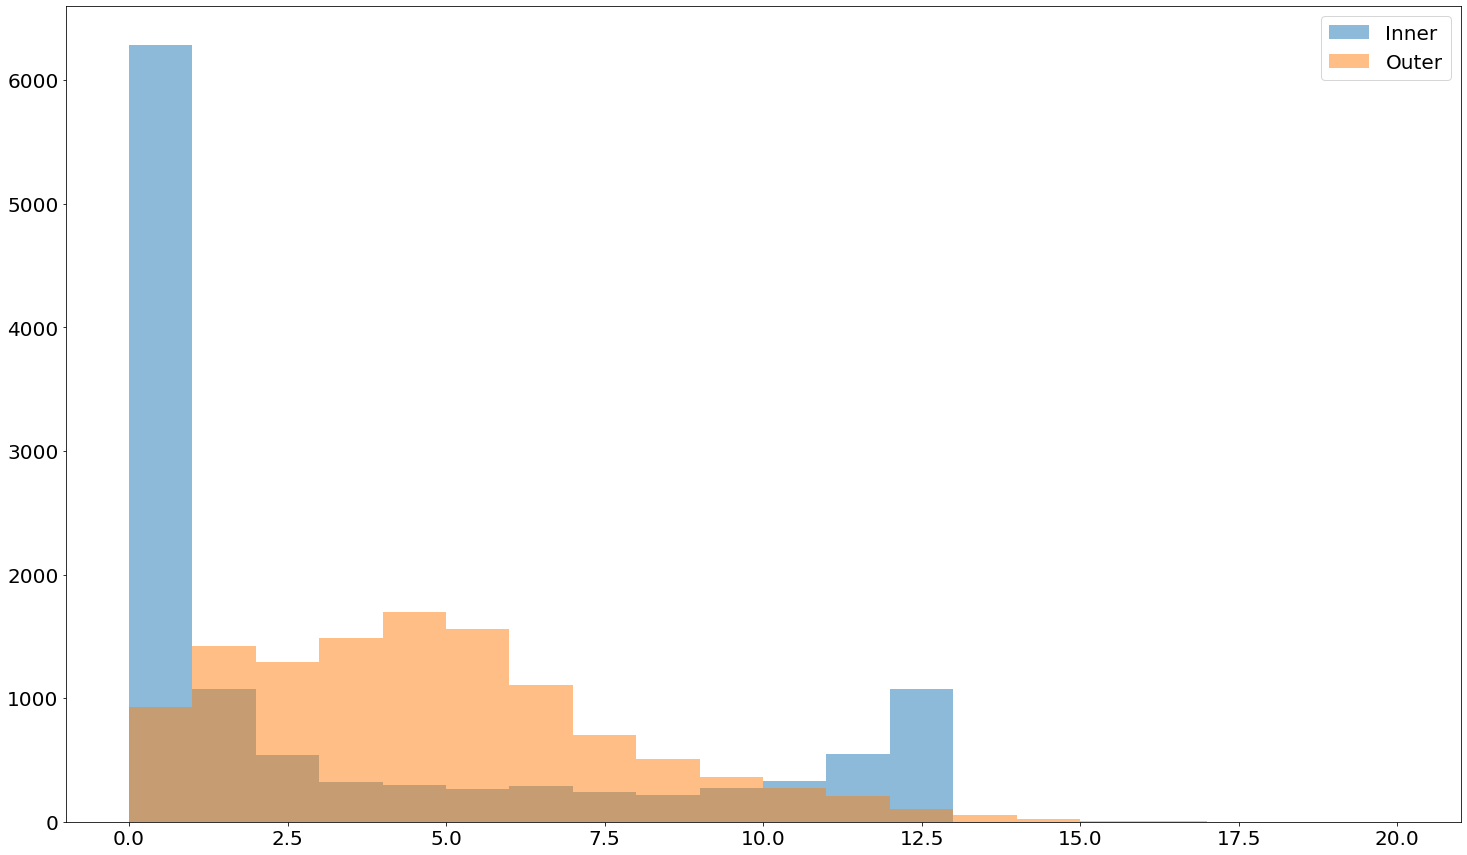

In [42]:
bins=np.linspace(0, 20, 21)
alpha=.5
plt.hist(feat.NActiveSlices_inner, bins=bins, alpha=alpha, label="Inner")
plt.hist(feat.NActiveSlices_outer, bins=bins, alpha=alpha, label="Outer")
plt.legend()
plt.show()

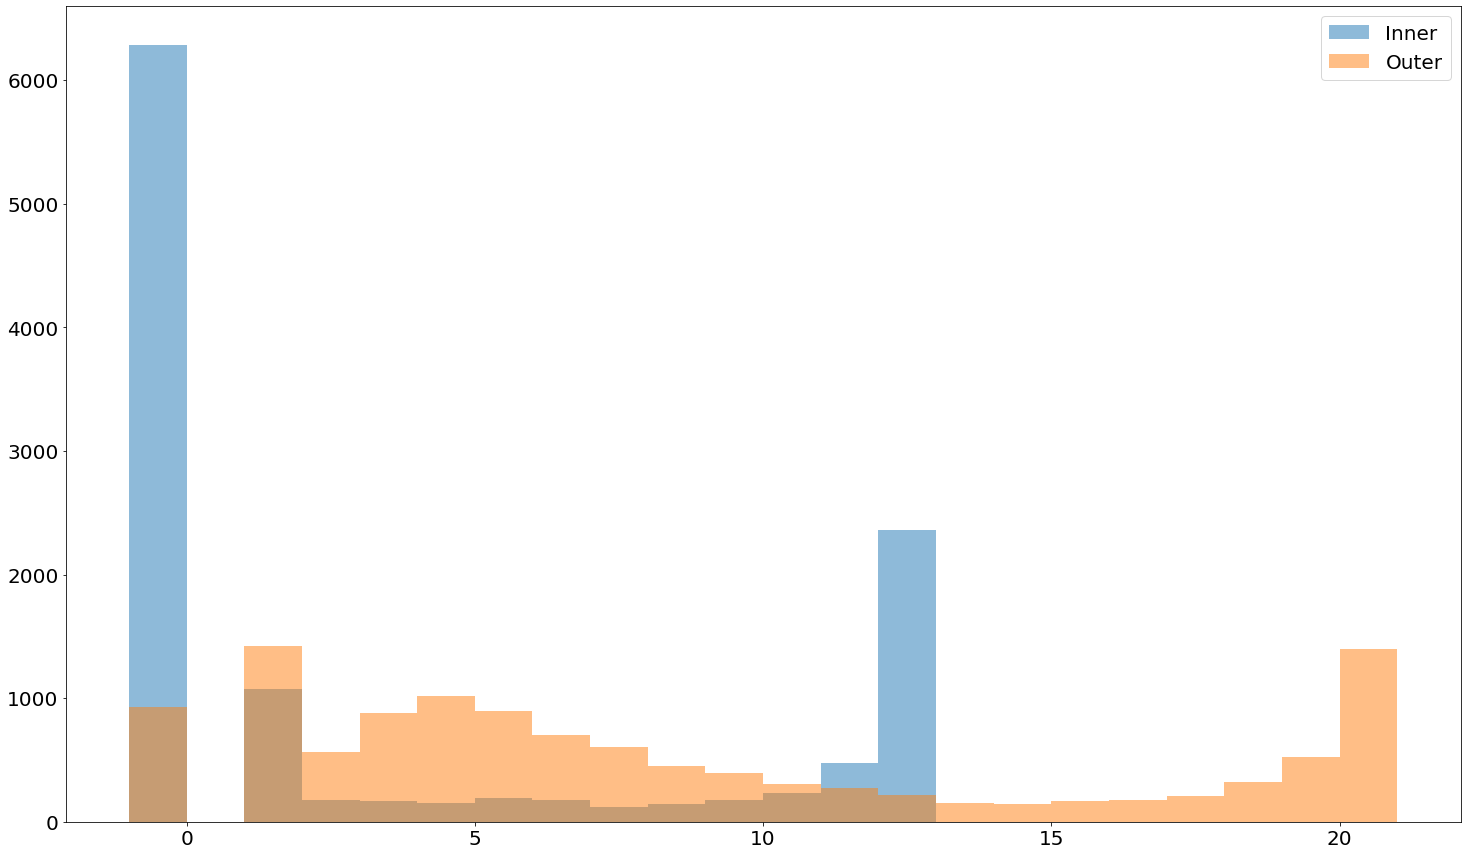

In [50]:
bins=np.linspace(-1, 21, 23)
alpha=.5
plt.hist(feat.SpatialRange_inner, bins=bins, alpha=alpha, label="Inner")
plt.hist(feat.SpatialRange_outer, bins=bins, alpha=alpha, label="Outer")
plt.legend()
plt.show()

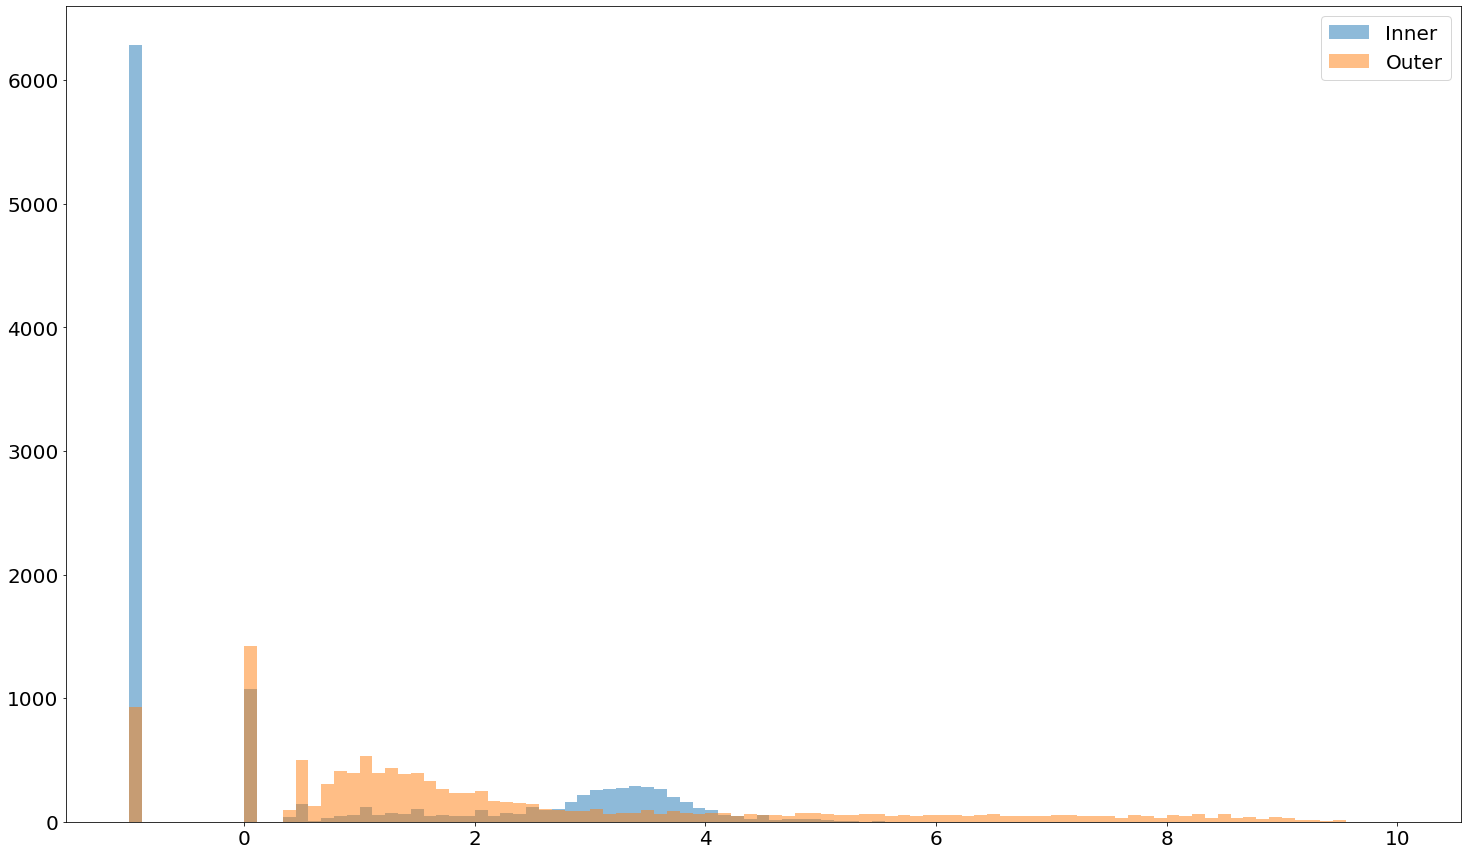

In [49]:
bins=np.linspace(-1, 10, 100)
alpha=.5
plt.hist(feat.SpatialStd_inner, bins=bins, alpha=alpha, label="Inner")
plt.hist(feat.SpatialStd_outer, bins=bins, alpha=alpha, label="Outer")
plt.legend()
plt.show()

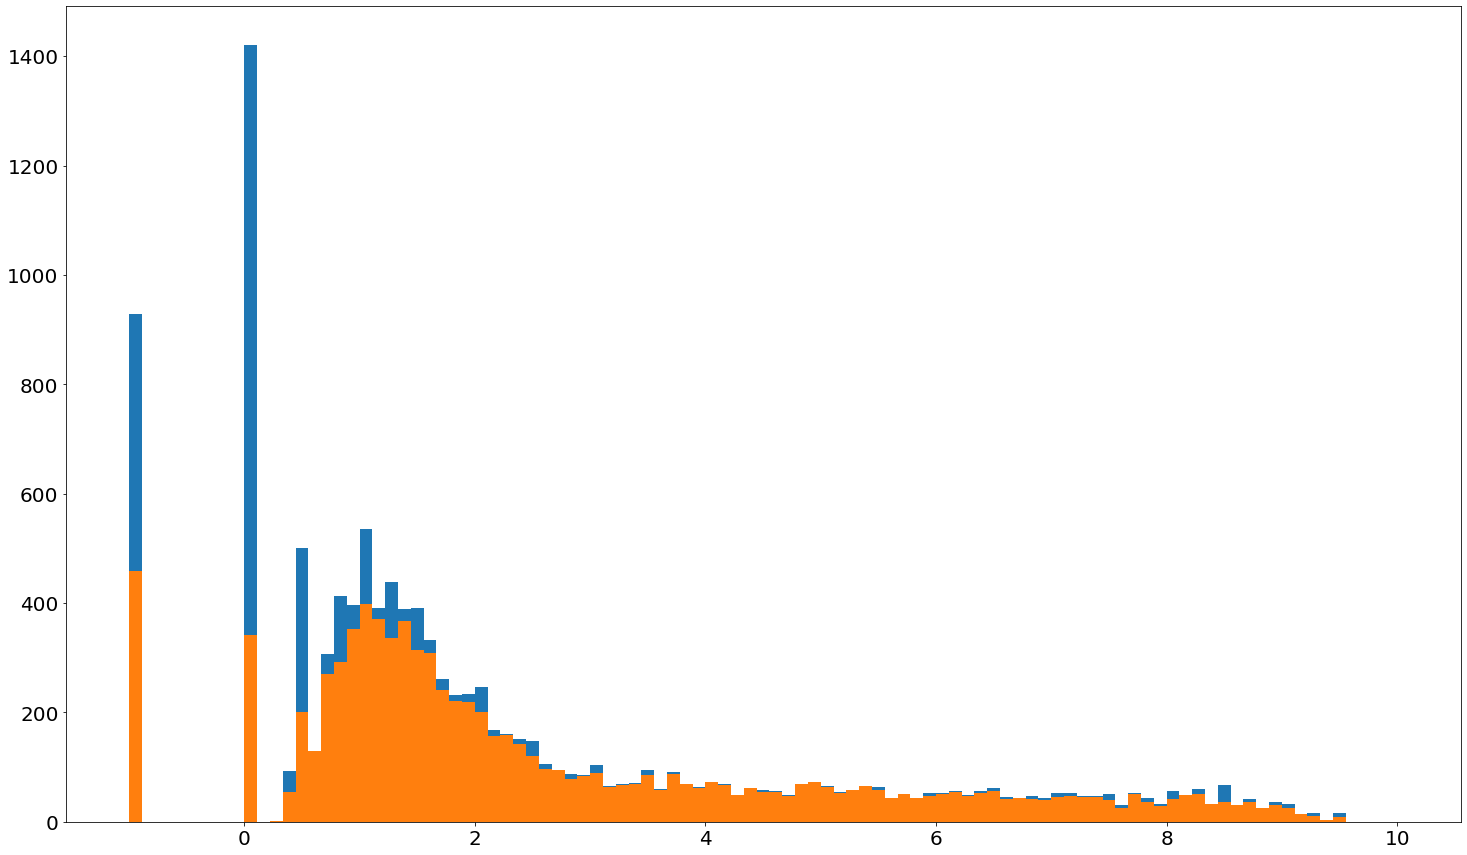

In [68]:
plt.hist(feat.SpatialStd_outer, bins=np.linspace(-1, 10, 100))
plt.hist(feat[feat.PEDetected_inner+feat.PEDetected_outer>=5].SpatialStd_outer, bins=np.linspace(-1, 10, 100))
plt.show()

In [79]:
df_ar41[df_ar41.eventnumber==147]

,eventnumber,energydeposition,pedetected,InnerSlice0,InnerSlice1,InnerSlice2,InnerSlice3,InnerSlice4,InnerSlice5,InnerSlice6,...,OuterSlice10,OuterSlice11,OuterSlice12,OuterSlice13,OuterSlice14,OuterSlice15,OuterSlice16,OuterSlice17,OuterSlice18,OuterSlice19
116,147,6174.52,128,5,7,14,5,2,3,5,...,0,0,0,0,0,0,0,1,0,3


In [72]:
feat

,PEDetected_inner,NActiveSlices_inner,SpatialRange_inner,SpatialStd_inner,PEDetected_outer,NActiveSlices_outer,SpatialRange_outer,SpatialStd_outer
0,2,2,8,3.500000,0,0,-1,-1.000000
1,0,0,-1,-1.000000,9,4,20,8.668091
2,0,0,-1,-1.000000,3,3,3,0.816497
3,0,0,-1,-1.000000,2,2,2,0.500000
4,0,0,-1,-1.000000,5,4,7,1.959592
...,...,...,...,...,...,...,...,...
11728,1,1,1,0.000000,11,5,19,8.149431
11729,20,6,12,4.290688,4,4,17,6.533567
11730,0,0,-1,-1.000000,16,4,4,0.866025
11731,0,0,-1,-1.000000,10,5,20,8.163333


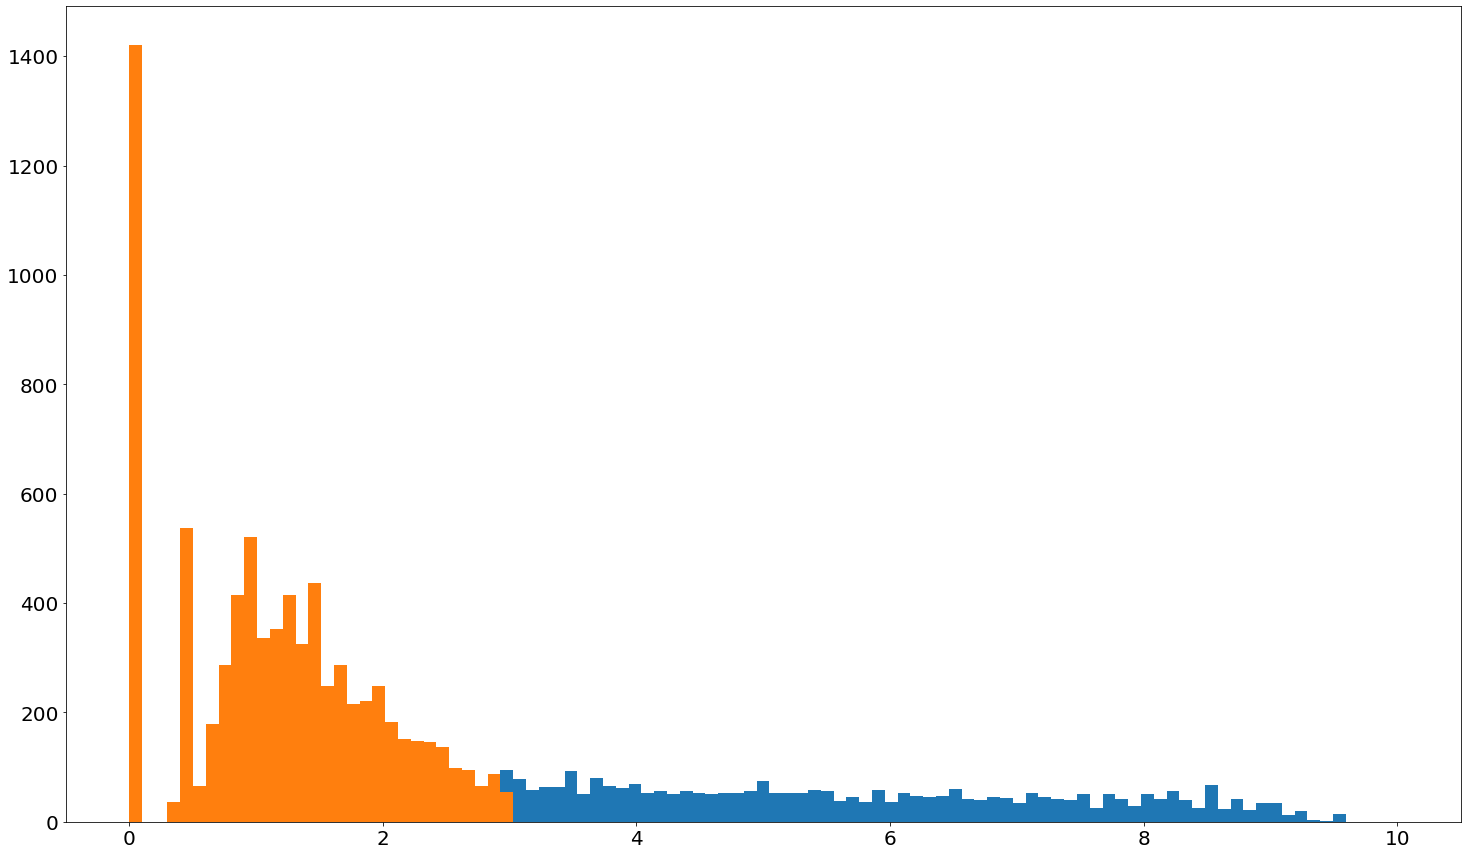

In [82]:
plt.hist(feat.SpatialStd_outer, bins=np.linspace(0, 10, 100))
plt.hist(feat[feat.SpatialStd_outer<3].SpatialStd_outer, bins=np.linspace(0, 10, 100))
plt.show()

In [84]:
filtered = feat[feat.SpatialStd_outer<3]
(filtered.PEDetected_outer).describe()


count    8639.000000
mean       10.518694
std        13.051214
min         0.000000
25%         2.000000
50%         6.000000
75%        14.000000
max       125.000000
Name: PEDetected_outer, dtype: float64

In [86]:
df_ar41[df_ar41.pedetected>5]

,eventnumber,energydeposition,pedetected,InnerSlice0,InnerSlice1,InnerSlice2,InnerSlice3,InnerSlice4,InnerSlice5,InnerSlice6,...,OuterSlice10,OuterSlice11,OuterSlice12,OuterSlice13,OuterSlice14,OuterSlice15,OuterSlice16,OuterSlice17,OuterSlice18,OuterSlice19
1,3,6308.63,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
5,8,4155.88,24,0,0,0,0,0,0,0,...,0,0,0,0,0,4,6,2,4,5
7,10,2587.41,31,1,0,2,2,0,0,0,...,0,2,1,2,10,5,0,0,0,0
8,11,4186.36,8,0,0,0,1,1,0,0,...,2,1,2,1,0,0,0,0,0,0
9,12,4682.38,45,3,7,1,2,2,0,1,...,0,0,0,0,0,0,0,0,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11727,14272,6432.17,10,0,0,0,0,1,0,0,...,0,0,0,0,0,0,2,4,3,0
11728,14273,6357.07,12,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,3
11729,14275,6211.06,24,6,6,2,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
11730,14276,5947.90,16,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
